In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as matimg
from scipy import stats
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from shutil import copyfile
import os
import torch
from torchvision import models

In [0]:
# !wget https://media.githubusercontent.com/media/commaai/speedchallenge/master/data/train.mp4
# # !rm -r train
# !mkdir train
# !ffmpeg -i train.mp4 'train/img%04d.jpg'
# !wget https://github.com/commaai/speedchallenge/raw/master/data/train.txt

In [0]:
!wget https://media.githubusercontent.com/media/commaai/speedchallenge/master/data/test.mp4
# !rm -r test
!mkdir test
!ffmpeg -i test.mp4 'test/img%04d.jpg'

--2020-06-02 18:55:13--  https://media.githubusercontent.com/media/commaai/speedchallenge/master/data/test.mp4
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66954539 (64M) [application/octet-stream]
Saving to: ‘test.mp4’

test.mp4            100%[===================>]  63.85M   176MB/s    in 0.4s    

2020-06-02 18:55:15 (176 MB/s) - ‘test.mp4’ saved [66954539/66954539]

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa

In [0]:
speeds = pd.read_csv('./train.txt', header=None)
speeds = speeds.values
len(speeds)

20400

### Data Description:
-    data/train.mp4 is a video of driving containing 20400 frames. Video is shot at 20 fps.
-    data/train.txt contains the speed of the car at each frame, one speed on each line.
-    data/test.mp4 is a different driving video containing 10798 frames. Video is shot at 20 fps.


Copied from https://github.com/commaai/speedchallenge

In [0]:
print('Statistics of Speed Distribution')
print(stats.describe(speeds))

Statistics of Speed Distribution
DescribeResult(nobs=20400, minmax=(array([0.]), array([28.130404])), mean=array([12.18318166]), variance=array([67.35095656]), skewness=array([0.17719878]), kurtosis=array([-1.36264429]))


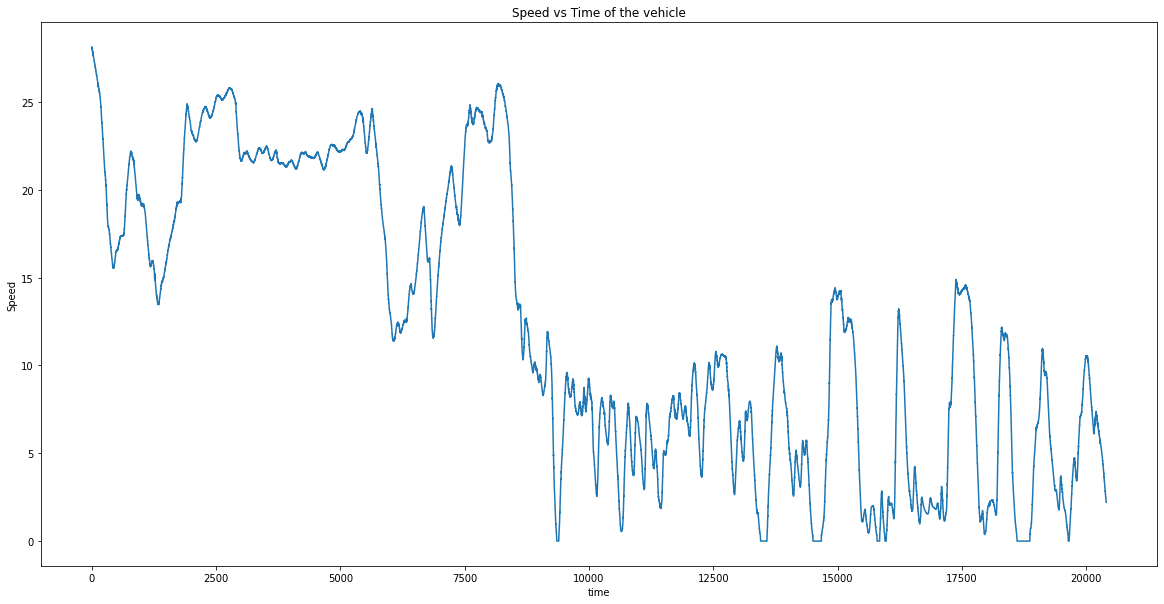

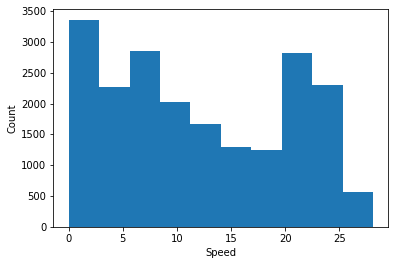

In [0]:
plt.figure(figsize=(20,10))
plt.title('Speed vs Time of the vehicle')
plt.plot(speeds)
plt.xlabel('time')
plt.ylabel('Speed')
plt.show()


plt.ylabel('Count')
plt.xlabel('Speed')
plt.hist(speeds)
plt.show()

In [0]:
!ls train/ | wc -l

20400


In [0]:
file_addresses = []
for fn in os.listdir('train/'):
    file_addresses.append('train/' + fn)

In [0]:
file_addresses = sorted(file_addresses)

In [0]:
test_file_addresses = []
for fn in os.listdir('test/'):
    test_file_addresses.append('test/' + fn)
test_file_addresses = sorted(test_file_addresses)

In [0]:
test_file_addresses[1]

'test/img0002.jpg'

## Shuffle Dataset

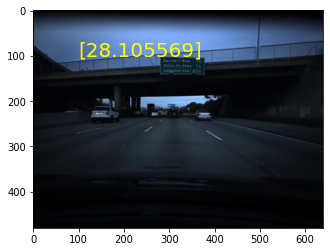

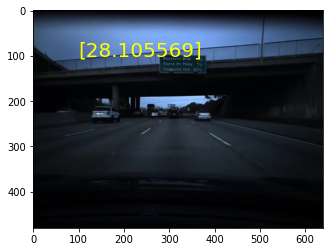

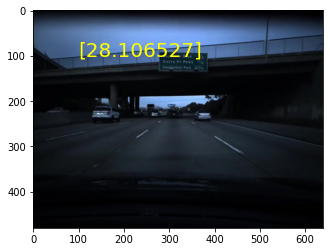

In [0]:
def view_img_speed(img_path):
  img = matimg.imread(img_path)
  idx = int(img_path.replace("train/img", '').replace('.jpg', '')) - 1
  plt.text(100,100,str(speeds[idx]), fontsize=20, color='yellow')
  plt.imshow(img)
  plt.grid(False)
  plt.show()

for idx in range(3):
    view_img_speed(file_addresses[idx])

In [0]:
X, y = shuffle(file_addresses, speeds)

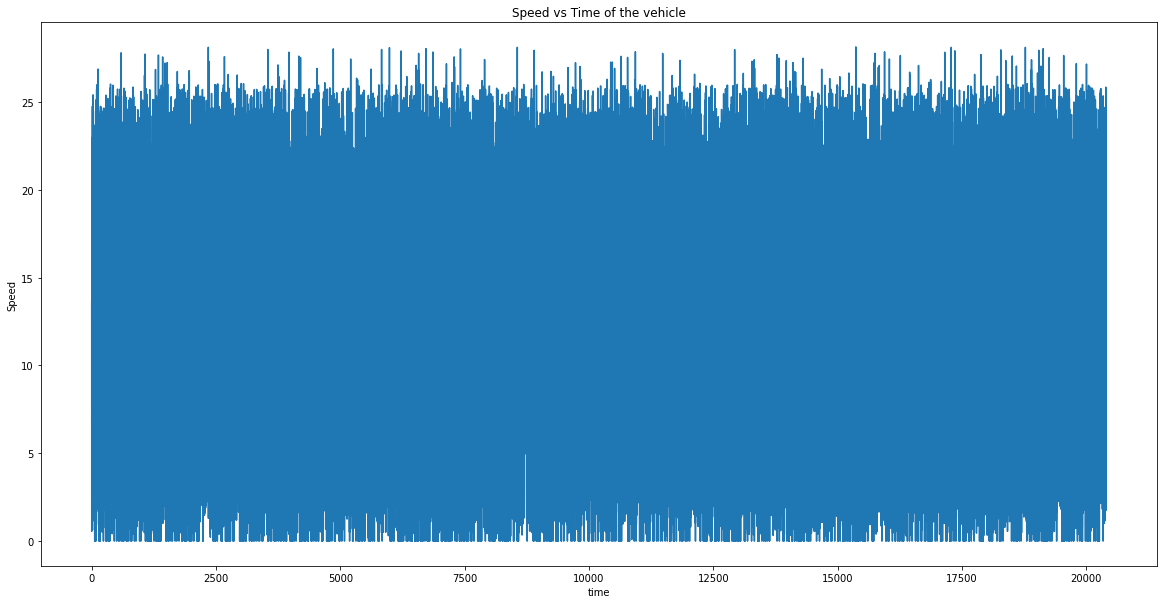

In [0]:
plt.figure(figsize=(20,10))
plt.title('Speed vs Time of the vehicle')
plt.plot(y)
plt.xlabel('time')
plt.ylabel('Speed')
plt.show()

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10)

In [0]:
!ls

drive  sample_data  train  train.mp4  train.txt


In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
from skimage import io, transform
data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'VAL': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    'TEST': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

In [0]:
class myDataset(Dataset):
    def __init__(self, addresses, speeds, transform=None):
        self.addresses = addresses
        self.speed = speeds
        self.transform = transform

    def __len__(self):
        return len(self.addresses)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = self.addresses[idx]
        image = matimg.imread(img_path)
        if self.transform:
            image = self.transform(image)
        if self.speed is None:
            return image
        else:
            return image, self.speed[idx]

# trainDataset = myDataset(X_train, y_train, data_transforms['TRAIN'])
# valDataset = myDataset(X_val, y_val, data_transforms['VAL'])

# train_loader = torch.utils.data.DataLoader(trainDataset, batch_size=32,shuffle=True, num_workers=4)
# val_loader = torch.utils.data.DataLoader(valDataset, batch_size=32,shuffle=True, num_workers=4)

testDataset = myDataset(test_file_addresses, None, data_transforms['TEST'])

test_loader = torch.utils.data.DataLoader(testDataset, batch_size=1,shuffle=False, num_workers=4)


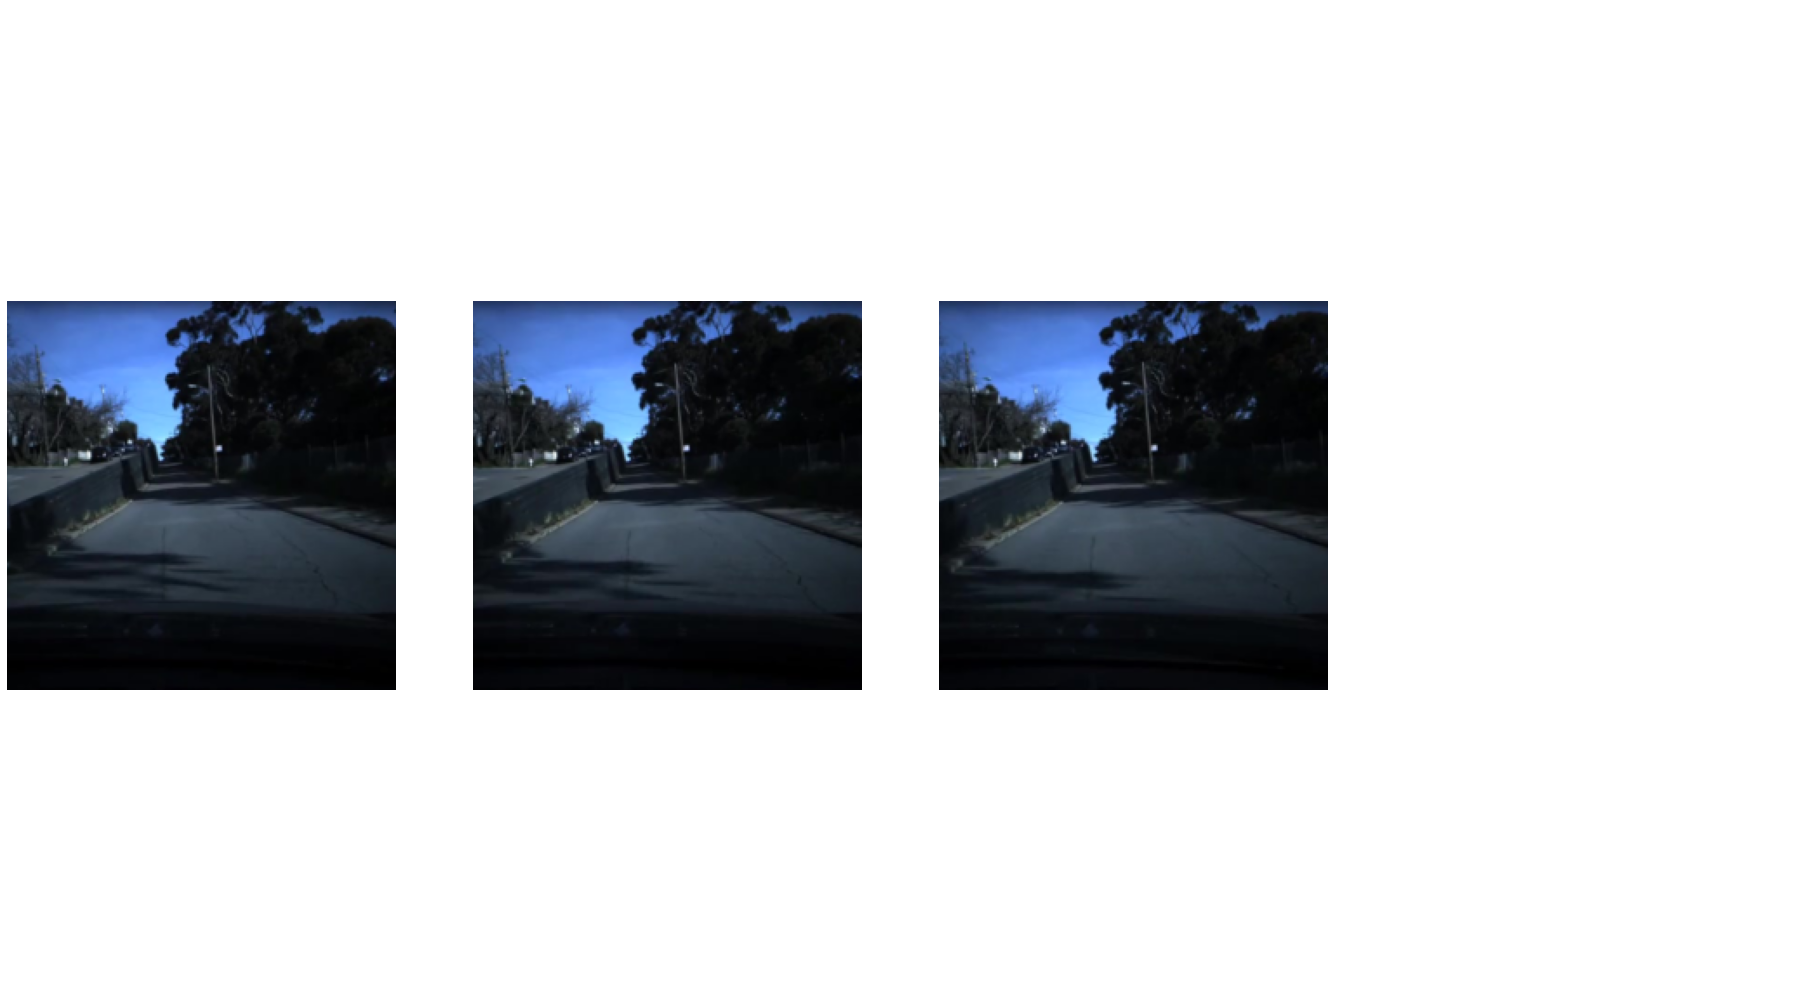

In [0]:
fig = plt.figure(figsize=(32,18))
for i in range(len(testDataset)):
    image = testDataset[i]
    plt.imshow(image.permute(1, 2, 0))
    ax = plt.subplot(1, 4, i + 1)
    # ax.set_title('Speed:%f' %speed)
    ax.axis('off')

    if i == 3:
        plt.show()
        break

### Load pretrained vgg19

In [0]:
net = models.vgg16(pretrained=False)

for param in net.parameters():
    param.requires_grad = True
    
num_features = net.classifier[3].in_features
features = list(net.classifier.children())[:-2] # Remove last layer
features.extend([nn.Linear(num_features, 2048), nn.Linear(2048, 1)]) # Add our layer with 4 outputs
net.classifier = nn.Sequential(*features) # Replace the model classifier
net = net.cuda()
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !mkdir '/content/drive/My Drive/SpeedTest'
!ls '/content/drive/My Drive/SpeedTest'

best_model-11e-valMSE-5.27.pt	 best_model.pt
best_model-18e-valLoss-2.834.pt  end_model_40e.pt


In [0]:
net.load_state_dict(torch.load('/content/drive/My Drive/SpeedTest/best_model.pt'))

<All keys matched successfully>

In [0]:
valid_loss_min = np.Inf
epochs = 30
steps = 0

train_losses, test_losses = [], []

In [0]:
# Eh, I am greedy for lesser loss.
# epochs = (30, 41)
for e in range(30, 41):
    print("Epoch: {}/{} ".format(e+1, epochs))
    running_loss = 0
    tr_accuracy = 0
    for images, labels in tqdm(train_loader):
        images = images.type(torch.FloatTensor).cuda()
        labels = labels.type(torch.FloatTensor).cuda()
        
        optimizer.zero_grad()
        
        out  = net(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            net.eval()
            for images, labels in val_loader:
                images = images.type(torch.FloatTensor).cuda()
                labels = labels.type(torch.FloatTensor).cuda()
                log_ps = net(images)
                test_loss += criterion(log_ps, labels)

        
        net.train()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(val_loader))

        print("  Training Loss: {:.3f} ".format(train_losses[-1]),
              "Validation Loss: {:.3f} ".format(test_losses[-1]))
        if test_loss/len(val_loader) <= valid_loss_min:
            print('Saving model ...')
            torch.save(net.state_dict(), '/content/drive/My Drive/SpeedTest/best_model.pt')
            valid_loss_min = test_loss/len(val_loader)
            torch.save(net.state_dict(), '/content/drive/My Drive/SpeedTest/best_model.pt')

Epoch: 31/30 



  Training Loss: 11.126  Validation Loss: 3.479 
Epoch: 32/30 



  Training Loss: 12.074  Validation Loss: 5.209 
Epoch: 33/30 



  Training Loss: 11.191  Validation Loss: 3.274 
Epoch: 34/30 



  Training Loss: 10.343  Validation Loss: 2.435 
Epoch: 35/30 



  Training Loss: 11.179  Validation Loss: 2.404 
Epoch: 36/30 



  Training Loss: 10.450  Validation Loss: 2.671 
Epoch: 37/30 



  Training Loss: 11.166  Validation Loss: 2.521 
Epoch: 38/30 



  Training Loss: 10.851  Validation Loss: 2.499 
Epoch: 39/30 



  Training Loss: 11.453  Validation Loss: 2.278 
Saving model ...
Epoch: 40/30 



  Training Loss: 11.771  Validation Loss: 4.131 
Epoch: 41/30 



  Training Loss: 10.774  Validation Loss: 3.576 


In [0]:
cpu_test_losses = [loss.cpu().numpy() for loss in test_losses]

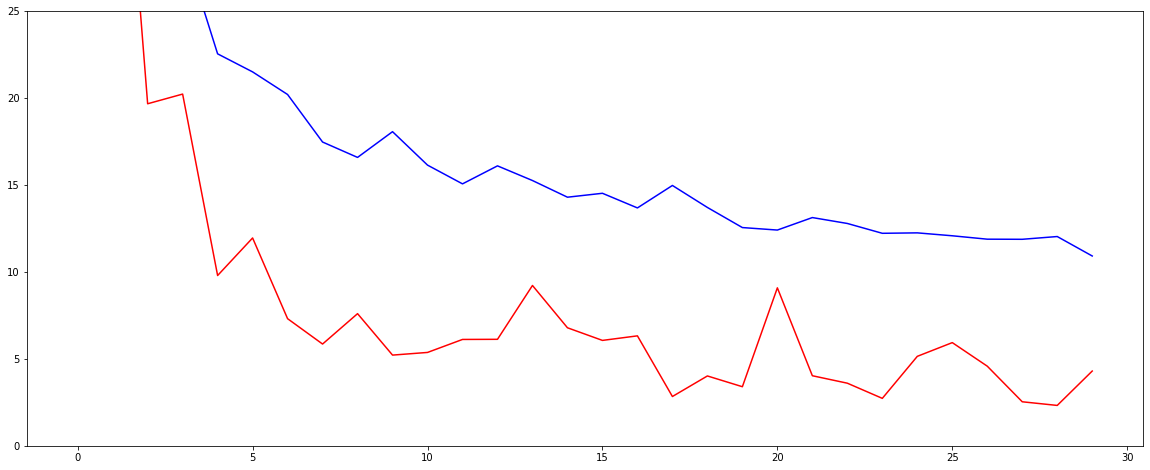

In [0]:
plt.figure(figsize=(20, 8))
plt.plot(train_losses, 'b', label='Training Loss')
plt.plot(cpu_test_losses, 'r', label='Validation Loss')
plt.ylim([0, 25])
plt.show()

In [0]:
torch.save(net.state_dict(), '/content/drive/My Drive/SpeedTest/end_model_40e.pt')

In [0]:
out_speed = np.array((1, len(test_loader)))
with torch.no_grad():
    net.eval()
    idx = 0
    for images in tqdm(test_loader):
        images = images.type(torch.FloatTensor).cuda()
        out = net(images)
        out_speed[idx] = out.cpu().data
        idx += 1

In [0]:
y_pred = np.array(out_speed)

In [0]:
y_pred[0][0]

In [0]:
np.savetxt('/content/drive/My Drive/SpeedTest/test.txt', y_pred.flatten())

In [0]:
y_pred.shape